# Clustering the Tokyo, Japan Airbnb listings made by superhosts by room features, booking, and review features

by Nika Espiritu and Daryll Tumambing

## Executive Summary 

What characterizes superhost listings?  What are the types of superhost listings, such that a traveler can discern where they should stay?  For these superhosts, what can they do to stand amongst other superhosts? 

To answer this, the Airbnb `listings` dataset of Tokyo, Kantō, Japan was used.  A pre-COVID scenario was considered; thus, the December 30, 2019 crawl date was used.   The dataset was then trimmed down by only taking the listings posted by superhosts. From here, the researchers conducted clustering on the resulting superhosts dataset and searched for common characteristics between the listings through an exploratory data analysis on each cluster found. 

By conducting principal component analysis and k-medians clustering, the researchers were able to come up with 3 distinct clusters, fit for 3 customer types: high-paying guests, families, and budget travelers.  Distinct features of each cluster were identified through exploratory data analysis on variables related to property type, price, ratings, and amenities.  High-paying guests are faced with cost-inefficient Airbnb listings.  Families are presented with listings that are more spacious and have more family-friendly amenities. Finally, budget travelers can choose from budget-friendly options, all rich with amenities similar to listings fit for families. 

## Introduction

Airbnb has been known as a disruptor in the hospitality industry with the numerous listings available on the platform that rival the experience provided by typical hotels and hostels.  However, a key distinction of one listing from another is the “superhost” badge placed on it.  With this badge, superhosts are able to have prime spots on search results.  They may also command a higher price point, given the extra visibility and trust placed on them. 

With this in mind, the researchers are interested in answering the following question: what characterizes superhost listings?  What are their similarities and differences?  For existing and incoming Airbnb hosts, this is an interesting problem, as this paper provides insights on getting ahead in the Airbnb market.  For travelers, they are given insights on the typical Airbnb in an area.  Most importantly, this paper gives insights on the inherent customer segmentation done by Airbnb. 

The researchers used the Airbnb `listings` dataset of Tokyo, Kantō, Japan, found on Jojie.  The latest pre-COVID scenario was considered in the analysis, i.e. December 30, 2019, thus pertaining to all listings found on the Airbnb platform on December 30, 2019. After conducting data pre-processing, principal component analysis, and k-means and k-medians clustering were conducted.

## Dataset 

The researchers utilized the `listings.csv.gz` Airbnb dataset of Tokyo, Kantō, Japan from the 30 December 2019 crawl date. The following libraries were used to aid in the analysis.

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import sys
import os
import json
import re
import gzip
import seaborn as sns
from tqdm.autonotebook import tqdm
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.metrics import calinski_harabasz_score, silhouette_score
from sklearn.cluster import KMeans
from pyclustering.cluster.kmedians import kmedians
import folium
import IPython
np.set_printoptions(threshold=sys.maxsize)

<ipython-input-1-e1212b0ab976>:10: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
listings_df = pd.read_csv('/mnt/data/public/insideairbnb/data.insideairbnb.com/'
                          'japan/kantō/tokyo/2019-12-30/data/listings.csv.gz', 
                          compression='gzip',
                          low_memory=False)
print(listings_df.shape)
listings_df.head(5)

(14550, 106)


,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,35303,https://www.airbnb.com/rooms/35303,20191230223155,2019-12-30,"La Casa Gaienmae C Harajuku, Omotesando is nearby",This shared flat is locating at very close to ...,This apartment is 3 bedroom flat shared with t...,This shared flat is locating at very close to ...,none,10 min walking to Harajuku ~ Urahara ~ Omotesa...,...,f,f,strict_14_with_grace_period,f,f,3,2,1,0,0.18
1,197677,https://www.airbnb.com/rooms/197677,20191230223155,2019-12-31,Oshiage Holiday Apartment,NaN,"We are happy to welcome you to our apartment, ...","We are happy to welcome you to our apartment, ...",none,NaN,...,f,f,moderate,f,f,1,1,0,0,1.62
2,289597,https://www.airbnb.com/rooms/289597,20191230223155,2019-12-31,Private apt in central Tokyo #203,NaN,::::::::::::::::::::::::::::::::::::::::::::::...,::::::::::::::::::::::::::::::::::::::::::::::...,none,NaN,...,t,f,strict_14_with_grace_period,f,f,2,2,0,0,1.22
3,370759,https://www.airbnb.com/rooms/370759,20191230223155,2019-12-31,"Cozy flat #203, local area YET 10 mins to shib...","So close to busy centers, yet so peaceful! Jus...","Cozy and Relaxing, at home feeling in a reside...","So close to busy centers, yet so peaceful! Jus...",none,Peaceful and residential area just 10 mins awa...,...,t,f,strict_14_with_grace_period,f,f,3,3,0,0,1.45
4,700253,https://www.airbnb.com/rooms/700253,20191230223155,2019-12-31,Private apt in central Tokyo #201,NaN,::::::::::::::::::::::::::::::::::::::::::::::...,::::::::::::::::::::::::::::::::::::::::::::::...,none,NaN,...,f,f,strict_14_with_grace_period,f,f,2,2,0,0,1.17


### Data pre-processing 

All listings made by superhosts were first isolated.  

In [3]:
superhosts_listings_df = listings_df[listings_df['host_is_superhost']=='t']

The following columns were dropped because all these are non-existent: `thumbnail_url`, `medium_url`, `xl_picture_url`, `neighbourhood_group_cleansed`, `jurisdiction_names`, `host_acceptance_rate`, and `experiences_offered`.   These may have been phased out as the Airbnb dataset evolved. 

In [4]:
superhosts_listings_df = superhosts_listings_df.drop(['thumbnail_url', 
         'medium_url', 'xl_picture_url', 'neighbourhood_group_cleansed', 
         'jurisdiction_names', 'host_acceptance_rate', 
         'experiences_offered'], axis=1)

The following columns were dropped because all listings have similar values in these columns. 

1. `is_business_travel_ready`: signifies if an Airbnb listing is ready for business travel, and interestingly all listings are *not* ready for business travel.  This may also be traced back to the researchers' chosen crawl date: December 30, 2019, a date covered by the holiday season. 
2. `requires_license`: signifies if a host requires a license from the guest to be able to stay. This will be discussed more on _[blank]_. All listings surprisingly require a license. 
3. `license`: details out a host's license.  All listings of superhosts have a registered license. 
4. `has_availability`: All listings are available. 
5. `country_code`: All listings follow the `JP` code. 
6. `country`: All listings specify `Japan`. 
7. `host_is_superhost`: All listings are owned by superhosts. 
8. `state`: All listings are found in Tokyo. 

In [5]:
superhosts_listings_df = superhosts_listings_df\
                            .drop(['is_business_travel_ready',
                                   'requires_license', 'license',
                                   'has_availability', 'country_code',
                                   'country', 'host_is_superhost', 'state'], 
                                  axis=1)

With the various data types present in the dataset, the columns of the dataset were sorted for batch processing: `existence_columns`, `to_split_columns`, `boolean_columns`, `numerical_columns`, `process_to_numerical_columns`, `dummify_columns`, and `ordinal_columns`.

`existence_columns` pertained to text data that described a particular listing.  For ease of analysis, this will be converted into Boolean variables, 1 if it contains text and 0 if none. 

In [6]:
existence_columns = ['summary', 'space', 
                     'description', 'neighborhood_overview', 
                     'notes', 'transit', 'access', 'interaction', 
                     'house_rules', 'host_location', 'host_about', 
                     'host_neighbourhood', 'street', 'neighbourhood', 
                     'smart_location']

In [7]:
superhosts_listings_df[existence_columns + 
                       list(map(lambda x: f'contains_{x}', 
                                existence_columns))] = \
                        superhosts_listings_df[existence_columns].\
                        assign(**{f'contains_{k}': 
                                  superhosts_listings_df[k].isna().\
                                  apply(lambda x: 0 if x else 1) 
                                  for k in existence_columns})
superhosts_listings_df[superhosts_listings_df.columns[\
        superhosts_listings_df.columns.str.contains('contains_')]].head(5)

,contains_summary,contains_space,contains_description,contains_neighborhood_overview,contains_notes,contains_transit,contains_access,contains_interaction,contains_house_rules,contains_host_location,contains_host_about,contains_host_neighbourhood,contains_street,contains_neighbourhood,contains_smart_location
1,0,1,1,0,0,0,0,0,1,1,1,1,1,1,1
5,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
7,1,1,1,0,0,1,1,1,1,1,1,1,1,1,1
8,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1
9,1,1,1,1,1,1,1,1,1,1,1,0,1,0,1


`to_split_columns` pertain to `host_verifications` and `amenities`.  Both are lists encoded as a string variable. `host_verifications` details out the various methods as to how a superhost is verified.  A listing with `[Facebook, Government ID, Email]` means the host of the listing is verified based on these methods.  The list can contain any of the following verification methods: `weibo`, `zhima_selfie`, `reviews`, `government_id`, `kba`, `facebook`, `offline_government_id`, `google`, `sesame_offline`, `selfie`, `jumio`, `work_email`, `manual_offline`, `manual_online`, `identity_manual`, `phone`, `sesame`, `email`, or `sent_id`. Host verifications was converted into Boolean variable, one column for each method. It takes the value of 1 if the host is verified through the method, and 0 if not.

Each listing also has an `amenities`, a list containing all the available amenities in an Airbnb.  A listing can have 154 possible amenities to detail out which covers items related to the kitchen, bathroom, parking, laundry, entertainment options, accessibility features for persons with disabilities, as well as child-friendly features (e.g. crib, toys for babies), among others.  This was split and turned into a Boolean variable, one column for each method.  It takes the value of 1 if the amenity exists in the Airbnb listing, and 0 if not. 

In [8]:
to_split_columns = ['host_verifications', 'amenities']

In [9]:
superhosts_listings_df.loc[\
           superhosts_listings_df['host_verifications']=='None', 
                           ['host_verifications']] = '[]'


host_verifications = superhosts_listings_df[to_split_columns]\
                                            ['host_verifications']

set_host_verifications = set()
[[set_host_verifications.add(hv) for hv in y] for 
 y in list(map(lambda x: json.loads(x.replace("'", '"')),
               host_verifications))]
set_host_verifications = list(set_host_verifications)

superhosts_listings_df = superhosts_listings_df.assign(\
    **{f'host_verifications_{k}':0 for k in set_host_verifications})
for idx, hvs in tqdm(enumerate(list(map(lambda x: 
                                        json.loads(x.replace("'", '"')), 
                                        host_verifications)))):
    for hv in hvs:
        superhosts_listings_df[f'host_verifications_{hv}'].iloc[idx] = 1

0it [00:00, ?it/s]

/opt/conda/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [10]:
amenities = superhosts_listings_df[to_split_columns]['amenities']
set_amenities = set()
amnty_pattern = re.compile(r'(,)?(\w+),')

[[set_amenities.add(amnty.replace('"', '')) for amnty in y.split(',')] 
 for y in list(map(lambda x: 
                   amnty_pattern.sub(r'\1"\2",', x[1:-1]), amenities))]
set_amenities = list(filter(lambda x: x, (set_amenities)))
# set_amenities

superhosts_listings_df = superhosts_listings_df.assign(**{f'amenities_{k}':0 
                                                          for k in 
                                                          set_amenities})
for idx, amntis in tqdm(enumerate([[amnty.replace('"', '') for amnty in 
                                    y.split(',')] for y in 
                                   list(map(lambda x: 
                                            amnty_pattern.sub(r'\1"\2",', 
                                                              x[1:-1]), 
                                            amenities))])):
    for amnty in amntis:
        if amnty:
            superhosts_listings_df[f'amenities_{amnty}'].iloc[idx] = 1

0it [00:00, ?it/s]

The original Boolean columns listed below can take a value of  `t` or `f`.  These were changed to `1` and `0`, respectively. 

In [11]:
boolean_columns = ['host_has_profile_pic', 'host_identity_verified', 
                   'is_location_exact', 'instant_bookable', 
                   'require_guest_profile_picture', 
                   'require_guest_phone_verification']

In [12]:
superhosts_listings_df[boolean_columns] = \
    superhosts_listings_df[boolean_columns].applymap(lambda x: 1 if x == 't' else 0)

Columns that refer to price were originally encoded as string values because of the presence of currency.  These were transformed into float variables.   

In [13]:
numerical_columns = ['host_listings_count', 'accommodates', 
                     'bathrooms', 'bedrooms', 
                     'beds', 'square_feet', 
                     'cleaning_fee', 'guests_included', 
                     'minimum_nights', 'maximum_nights', 
                     'minimum_minimum_nights', 'maximum_minimum_nights', 
                     'minimum_maximum_nights', 'maximum_maximum_nights', 
                     'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 
                     'availability_30', 'availability_60', 'availability_90',
                     'availability_365', 'number_of_reviews', 
                     'number_of_reviews_ltm', 'review_scores_rating', 
                     'review_scores_accuracy', 'review_scores_cleanliness', 
                     'review_scores_checkin', 'review_scores_communication', 
                     'review_scores_location', 'review_scores_value', 
                     'calculated_host_listings_count', 
                     'calculated_host_listings_count_entire_homes', 
                     'calculated_host_listings_count_private_rooms', 
                     'calculated_host_listings_count_shared_rooms', 
                     'reviews_per_month']

In [14]:
process_to_numerical_columns = ['price', 'weekly_price', 
                                'monthly_price', 'security_deposit', 
                                'cleaning_fee', 'extra_people']

In [15]:
numerical_patterns = re.compile(r'[,|\$]')
superhosts_listings_df[process_to_numerical_columns] = \
    superhosts_listings_df[process_to_numerical_columns].fillna('-1').\
    applymap(lambda x: numerical_patterns.sub('', str(x))).astype(float)

In [16]:
superhosts_listings_df['host_response_rate'] = \
    superhosts_listings_df['host_response_rate'].str.replace('%', 
                                                             '').astype(float)

Categorical variables were transformed into dummy variables. This will be dummified along with the rest of the dataset.

In [17]:
dummify_columns = ['property_type', 'room_type', 'bed_type', 
                   'cancellation_policy', 'market']

Finally, `host_response_time` was transformed into an ordinal variable instead of a categorical variable, as it can take any of the following values: `within an hour`, `within a few hours`, `within a day`, `a few days or more`. These variables were replaced with 0, 1, 2, and 3, respectively. 

In [18]:
ordinal_columns = ['host_response_time']

In [19]:
superhosts_listings_df['host_response_time'] = \
    superhosts_listings_df['host_response_time']\
                            .map({'within an hour': 0, 
                                  'within a few hours': 1, 
                                  'within a day': 2, 
                                  'a few days or more': 3})
superhosts_listings_df['cancellation_policy'] = \
    superhosts_listings_df['cancellation_policy']\
                            .map({'flexible': 0, 
                                  'moderate': 1, 
                                  'strict_14_with_grace_period': 2, 
                                  'strict': 3, 'super_strict_30': 4, 
                                  'super_strict_60': 5})

In [20]:
superhosts_listings_df = superhosts_listings_df.drop(existence_columns, axis=1)
superhosts_listings_df.head(5)

,id,listing_url,scrape_id,last_scraped,name,picture_url,host_id,host_url,host_name,host_since,...,amenities_Free street parking,amenities_TV,amenities_Crib,amenities_Heating,amenities_Stove,amenities_Indoor fireplace,amenities_Convection oven,amenities_Host greets you,amenities_Suitable for events,amenities_Other
1,197677,https://www.airbnb.com/rooms/197677,20191230223155,2019-12-31,Oshiage Holiday Apartment,https://a0.muscache.com/im/pictures/38437056/d...,964081,https://www.airbnb.com/users/show/964081,Yoshimi & Marek,2011-08-13,...,0,1,0,1,0,0,0,0,0,0
5,776070,https://www.airbnb.com/rooms/776070,20191230223155,2019-12-31,Kero-kero house room 1,https://a0.muscache.com/im/pictures/efd9f039-d...,801494,https://www.airbnb.com/users/show/801494,Kotaro Kei And Litte Miya,2011-07-10,...,0,1,0,1,0,0,0,0,0,1
7,899003,https://www.airbnb.com/rooms/899003,20191230223155,2019-12-31,"Classy room @Shinjuku, Takadanoba",https://a0.muscache.com/im/pictures/20005274/1...,4799233,https://www.airbnb.com/users/show/4799233,Yu,2013-01-22,...,0,1,0,0,0,0,0,0,0,1
8,905944,https://www.airbnb.com/rooms/905944,20191230223155,2019-12-31,4F - Near Shinjuku & Shibuya w/Free WiFi,https://a0.muscache.com/im/pictures/16480116/b...,4847803,https://www.airbnb.com/users/show/4847803,Best Stay In Tokyo!,2013-01-25,...,0,1,0,1,1,0,0,0,0,0
9,1007534,https://www.airbnb.com/rooms/1007534,20191230223155,2019-12-31,Kichijoji Parkside Attic Room,https://a0.muscache.com/im/pictures/47a84ae5-d...,5068769,https://www.airbnb.com/users/show/5068769,Caroline,2013-02-13,...,0,0,0,1,0,0,0,1,0,0


The following columns were dropped from the `DataFrame`, as these will not be used in clustering: `listing_id`, `id`, `date`, `reviewer_id`, `reviewer_name`, `picture_url`, `host_thumbnail_url`, `host_picture_url`,`id_listings`, `listing_url`, `scrape_id`, `last_scraped`, `name`, `license`, `host_id`, `host_url`, `host_name`, `host_since`, `host_total_listings_count`, `host_total_listings_count`, `host_has_profile_pic`, `neighbourhood_cleansed`, `city`, `zipcode`, `first_review`, `last_review`. All pertain to scrape metadata, URLs, or dates.  The column `host_total_listings_count` will also be dropped, as it has the same values as `host_listings_count`. 

In [21]:
non_clustering_columns = ['id', 'picture_url', 'host_thumbnail_url', 
                          'host_picture_url', 'listing_url', 'scrape_id', 
                          'last_scraped', 'name',
                          'host_id', 'host_url', 'host_name', 
                          'host_since', 'host_total_listings_count', 
                          'host_total_listings_count', 'host_has_profile_pic', 
                          'neighbourhood_cleansed', 'city', 'zipcode',
                          'first_review', 'last_review', 'host_verifications', 
                          'amenities', 'calendar_last_scraped', 
                          'calendar_updated']
superhosts_listings_df = superhosts_listings_df.drop(non_clustering_columns, 
                                                     axis=1)
superhosts_listings_df.head(3)

,host_response_time,host_response_rate,host_listings_count,host_identity_verified,market,latitude,longitude,is_location_exact,property_type,room_type,...,amenities_Free street parking,amenities_TV,amenities_Crib,amenities_Heating,amenities_Stove,amenities_Indoor fireplace,amenities_Convection oven,amenities_Host greets you,amenities_Suitable for events,amenities_Other
1,2.0,100.0,1.0,1,Tokyo,35.71721,139.82596,1,Apartment,Entire home/apt,...,0,1,0,1,0,0,0,0,0,0
5,2.0,100.0,1.0,1,Tokyo,35.73818,139.77009,1,House,Private room,...,0,1,0,1,0,0,0,0,0,1
7,0.0,100.0,2.0,1,Tokyo,35.70865,139.69681,1,Apartment,Entire home/apt,...,0,1,0,0,0,0,0,0,0,1


The dataset's categorical variables were converted into dummy variables.

In [22]:
airbnb_df = pd.get_dummies(superhosts_listings_df)

After data cleanup, imputation was then performed for missing values.  The variables were sorted into two: columns for median imputation and columns for mode imputation.  Numerical variables were placed under median imputation, while Boolean variables were placed under mode imputation. 

Median imputation was used for variables pertaining to price instead of filling with 0, as it seems that though there are instances of USD 0 deposit fee or cleaning fee, it may be unlikely. According to [Airbnb](https://www.airbnb.com/help/article/2526/as-a-host-what-should-i-know-about-security-deposits#:~:text=Guests%20will%20be%20shown%20the,for%20Airbnb%2Drequired%20security%20deposits), they have a formula aside from the amount set by the host. This is further expounded below:

> Guests will be shown the amount of an Airbnb-required security deposit when they’re booking the reservation. We calculate the security deposit amount according to 60% of a listing’s nightly rate (this amount adjusts for longer stays). There is a USD 1,000 USD limit for Airbnb-required security deposits. 
If you require a security deposit for your listing and we also determine that one is required for a specific reservation, the amount that you set will be used. If the amount that you set is for USD 0, then the security deposit amount determined by Airbnb will be used. 

In [23]:
median_impute_cols = ['host_response_rate', 'host_listings_count', 
                      'accommodates', 'accommodates', 'bathrooms',
       'bedrooms', 'beds', 'square_feet', 'price', 'weekly_price',
       'monthly_price', 'security_deposit', 'cleaning_fee',
       'guests_included', 'extra_people', 'minimum_nights', 
       'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'availability_30', 'availability_60',
       'availability_90', 'availability_365', 'number_of_reviews',
       'number_of_reviews_ltm', 'review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value', 
       'calculated_host_listings_count',
       'calculated_host_listings_count_entire_homes',
       'calculated_host_listings_count_private_rooms',
       'calculated_host_listings_count_shared_rooms', 'reviews_per_month',]

mode_impute_cols = ['host_response_time', 'host_identity_verified', 
                    'is_location_exact','instant_bookable', 
                    'cancellation_policy',
       'require_guest_profile_picture',
       'require_guest_phone_verification'] \
+ list(airbnb_df.columns[airbnb_df.columns.str.contains('contains_')])\
+ list(airbnb_df.columns[airbnb_df.columns.str\
                         .contains('host_verifications_')])\
+ list(airbnb_df.columns[airbnb_df.columns.str.contains('amenities_')]) \
+ list(airbnb_df.columns[airbnb_df.columns.str.contains('market_')]) \
+ list(airbnb_df.columns[airbnb_df.columns.str.contains('property_type_')]) \
+ list(airbnb_df.columns[airbnb_df.columns.str.contains('room_type_')]) \
+ list(airbnb_df.columns[airbnb_df.columns.str.contains('bed_type_')])

In [24]:
airbnb_df[median_impute_cols] = pd.DataFrame(SimpleImputer(\
                                           missing_values=np.nan, 
                                           strategy='median').\
                                         fit_transform(\
                                           airbnb_df[median_impute_cols]), 
                                         columns=median_impute_cols).values
airbnb_df[median_impute_cols] = pd.DataFrame(SimpleImputer(\
                                               missing_values=-1, 
                                               strategy='median').\
                                             fit_transform(\
                                               airbnb_df[median_impute_cols]), 
                                             columns=median_impute_cols)\
                                                .values

In [25]:
remaining_mode_impute_cols = list(airbnb_df[mode_impute_cols].\
                                  columns[airbnb_df[mode_impute_cols]\
                                          .isna().all(0)==False])

airbnb_df[remaining_mode_impute_cols] = pd.DataFrame(
    SimpleImputer(missing_values=np.nan, strategy='most_frequent').\
    fit_transform(airbnb_df[mode_impute_cols]), 
    columns=remaining_mode_impute_cols).values

### Resulting dataset 

In [26]:
print("The resulting shape of the `DataFrame` is now at {}.".format(airbnb_df.shape))
airbnb_df.head(2)

The resulting shape of the `DataFrame` is now at (4385, 263).


,host_response_time,host_response_rate,host_listings_count,host_identity_verified,latitude,longitude,is_location_exact,accommodates,bathrooms,bedrooms,...,property_type_Villa,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room,bed_type_Airbed,bed_type_Couch,bed_type_Futon,bed_type_Pull-out Sofa,bed_type_Real Bed
1,2.0,100.0,1.0,1.0,35.71721,139.82596,1.0,4.0,1.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
5,2.0,100.0,1.0,1.0,35.73818,139.77009,1.0,2.0,1.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


## Methodology 

To understand different types of Airbnb superhosts, the researchers decided to group the listings into clusters of similar attributes. The following pipeline was done:: 

1. There were 3 scaling methods that were tried in the data, namely StandardScaler, MinMaxScaler and RobustScaler. **MinMaxScaler** provided the best end output. 
2. After using the appropriate scaling method, the researchers used sklearn’s **PCA** (Principal Component Analysis) to reduce the dimensions for better interpretability, less complexity, and easier visualization. 
3. Having the feature set’s dimension reduced, sklearn’s KMeans and pyclustering’s KMedians were performed and validated using different number of clusters **inertias** (within-cluster sum of squared errors) and **Calinski Harabasz scores (CH)** (ratio between the within-cluster dispersion and the between-cluster dispersion) 
4. Based on the graph, initially 4 k-means cluster was chosen to cluster the data. However, choosing 3 k-medians cluster provided better insights. The cluster prediction was assigned back to the dataset and exploratory data analysis was done. 

In [27]:
pca = PCA(n_components=2, random_state=42)
airbnb_pca_df = pca.fit_transform(MinMaxScaler().fit_transform(airbnb_df))

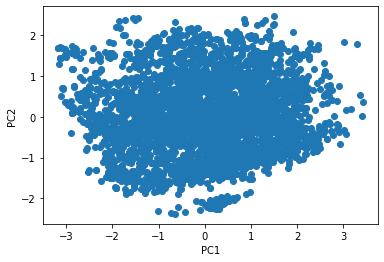

In [28]:
plt.scatter(airbnb_pca_df[:,0], airbnb_pca_df[:,1])
plt.xlabel('PC1')
plt.ylabel('PC2');

In [29]:
sss = []
chs = []
gss = []
sss_medians = []
chs_medians = []
gss_medians = []

for i in tqdm(range(2,10)):
    km = KMeans(n_clusters=i, random_state=0).fit(airbnb_pca_df)
    cluster_kmeans = km.predict(airbnb_pca_df)

    sss.append(km.inertia_)
    chs.append(calinski_harabasz_score(airbnb_pca_df, cluster_kmeans))
    
    initial_medians = airbnb_pca_df[:i]
    kmedians_instance_tmp = kmedians(airbnb_pca_df, initial_medians)

    kmedians_instance_tmp.process()
    cluster_kmedians = kmedians_instance_tmp.predict(airbnb_pca_df)

    sss_medians.append(kmedians_instance_tmp.get_total_wce())
    chs_medians.append(calinski_harabasz_score(airbnb_pca_df, cluster_kmedians))

  0%|          | 0/8 [00:00<?, ?it/s]

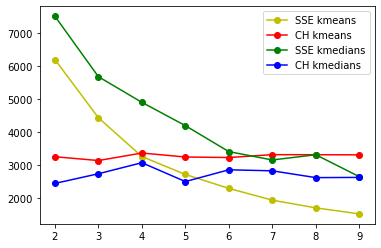

In [37]:
fig, ax = plt.subplots()
ks = np.arange(2, 10)
ax.plot(ks, sss, '-yo', label='SSE kmeans')
ax.plot(ks, chs, '-ro', label='CH kmeans')
ax.plot(ks, sss_medians, '-go', label='SSE kmedians')
ax.plot(ks, chs_medians, '-bo', label='CH kmedians')

ax.legend();

In [38]:
kmeans_instance = KMeans(n_clusters=4, random_state=0).fit(airbnb_pca_df)
kmeans_predictions = kmeans_instance.predict(airbnb_pca_df)

initial_medians = airbnb_pca_df[:3]
kmedians_instance = kmedians(airbnb_pca_df, initial_medians)

kmedians_instance.process()
kmedian_predictions = kmedians_instance.predict(airbnb_pca_df)

In [39]:
airbnb_df['kmeans_cluster'] = kmeans_predictions
airbnb_df['kmedians_cluster'] = kmedian_predictions

## Results and Discussion 

For consistency of findings, data preprocessing and outlined methodology was conducted on the following DataFrame.   This will be used in the followin results and discission.

In [40]:
airbnb_df = pd.read_csv('superhosts_cluster_minmax_imputed.csv.gz',
                      compression='gzip')

### Insight #1: Majority of listings available in Tokyo are apartments, but each cluster contained a unique mix of property types. 

To gain a basic understanding of the listings available in Tokyo, the researchers first sought to understand what property type is representative of each cluster.  Majority of the Tokyo listings for each cluster are classified as apartments, with 51-54% of Clusters 0 and 1 composed of apartments.  Notably, 81% of Cluster 2 is comprised of apartments.  However, the researchers also found interesting insights based on other property types.  Table 1 details the proportion of property types found in each cluster. 

In [41]:
prop_type_short = ['property_type_Aparthotel', 'property_type_Apartment',

          'property_type_Bed and breakfast', 'property_type_Boutique hotel',

          'property_type_Condominium', 'property_type_Hostel',

          'property_type_House', 'property_type_Ryokan (Japan)']
print("Table 1. Proportion of listings for each property in a cluster.")
display(pd.DataFrame(airbnb_df.groupby(by='kmedians_cluster')\
                     [prop_type_short].mean()))

Table 1. Proportion of listings for each property in a cluster.


,property_type_Aparthotel,property_type_Apartment,property_type_Bed and breakfast,property_type_Boutique hotel,property_type_Condominium,property_type_Hostel,property_type_House,property_type_Ryokan (Japan)
kmedians_cluster,,,,,,,,
0,0.025890,0.513269,0.012945,0.012945,0.029126,0.152751,0.155340,0.012945
1,0.016949,0.543341,0.000484,0.005327,0.047942,0.023245,0.276998,0.021792
2,0.009032,0.810323,0.000000,0.002581,0.058065,0.000000,0.077419,0.000000


**Cluster 0**: With half of Cluster 0 being apartments, two other major property types found here are hostels (15%) and houses (15%). Other property types found here are aparthotels (3%), condominiums (3%), boutique hotels (1%), and ryokan (1%). 

**Cluster 1**: Twenty eight percent (28%) of Cluster 1 listings are composed of houses, much larger spaces compared to apartments.  Other property types found here, albeit at small numbers, are condominiums (5%) and hostels (2%). 

**Cluster 2**: Aside from apartments (81%), also found here are houses (8%) and condominiums (5%). Interestingly, no bed and breakfasts, hostels, and Ryokans were placed in this cluster. A (ryokan (旅館))[https://www.japan-guide.com/e/e2029.html] is a type of traditional Japanese inn that typically feature tatami-matted rooms, communal baths, futon beds, and other public areas where visitors may wear yukata and talk with the owner. 

### Insight #2: Price tiering was found in clustering. 

With the aforementioned representative property types, then researchers then investigate on possible price tiering.  Table 2 shows the mean price features per cluster. 

In [42]:
related_to_price = ['price', 'security_deposit', 'cleaning_fee', 
                    'extra_people', 'accommodates']

print("Table 2. Median price features per cluster.")

pd.DataFrame(airbnb_df.groupby(by=['kmedians_cluster'])[related_to_price].\
       mean()).rename(columns={'price':'Price', 
                   'security_deposit':'Security deposit', 
                   'cleaning_fee':'Cleaning fee',
                   'extra_people':'Price per extra person',
                   'accommodates': 'Allowable number of guests'})\
        .applymap(lambda x: f'{x:,.2f}')

Table 2. Median price features per cluster.


,Price,Security deposit,Cleaning fee,Price per extra person,Allowable number of guests
kmedians_cluster,,,,,
0,"26,076.53","9,472.28","4,404.39","1,444.76",3.74
1,"19,470.35","17,641.03","6,662.35","2,017.72",5.02
2,"17,139.04","10,030.17","7,240.57","1,485.85",4.43


Across the clusters, it is apparent that a specific price tier exists here.  For the Airbnb dataset, this refers to the nightly price.  Security deposit and cleaning fee are an add-on to the total amount, and both adjust according to the length of stay.  Price per extra person refers to the cost of an additional guest exceeding the allowable number of guests.  

**Cluster 0**: Cluster 0 has the highest mean price at ¥ 26,076, but has the lowest security deposit, cleaning fee, and price per extra person.  However, it also houses the smallest number of allowable guests at 3.43, which proves that listings found here are not as cost efficient. 

**Cluster 1**: Cluster 1 has the highest allowable number of guests at 5.02 people, which point that these listings are perhaps targeted for families.  It also has the highest security deposit and price per extra person.  These listings can also be considered cost efficient, as it is cheaper than Cluster 0 listings at an average of ¥ 6,606. 

**Cluster 2**: Cluster 2 listings have the lowest mean price yet highest mean cleaning fee.  Cluster 2 listings are also targeted for average-sized groups of travelers at 4.4. 

### Insight #3: Guests agree that Cluster 0 listings are to be avoided. 

Table 3 shows the mean rating per cluster as well as the mean number of reviews per month. 

In [43]:
related_to_reviews = ['review_scores_rating',
                   'review_scores_cleanliness',
                   'review_scores_accuracy',
                   'review_scores_checkin',
                   'review_scores_communication',
                   'review_scores_location',
                   'review_scores_value',
                   'reviews_per_month']

print("Table 3. Mean rating features per cluster.")

pd.DataFrame(airbnb_df.groupby(by=['kmedians_cluster'])\
             [related_to_reviews].mean()).rename(columns={
                   'review_scores_rating':'Overall rating',
                   'review_scores_cleanliness': 'Rating on cleanliness',
                   'review_scores_accuracy':'Rating on accuracy',
                   'review_scores_checkin':'Rating on check-in',
                   'review_scores_communication': 'Rating on communication',
                   'review_scores_location':'Rating on location',
                   'review_scores_value':'Rating on value',
                   'reviews_per_month':'Reviews per month'})

Table 3. Mean rating features per cluster.


,Overall rating,Rating on cleanliness,Rating on accuracy,Rating on check-in,Rating on communication,Rating on location,Rating on value,Reviews per month
kmedians_cluster,,,,,,,,
0,95.894498,9.785113,9.838835,9.873139,9.880906,9.651133,9.453722,1.946104
1,96.892010,9.818886,9.897337,9.910412,9.924455,9.636804,9.557385,2.427840
2,96.141935,9.811613,9.889032,9.921290,9.900645,9.539355,9.501935,2.455819


As expected from superhost listings, features related to ratings will always be high.  However, there are still distinct features to be highlighted for each cluster. 

**Cluster 0**:  Cluster 0 has the lowest mean overall rating at 95.89. It also ranks the lowest on all aspects, except for location.  Because of its fairly low ratings, it is not booked as frequently compared to other clusters with only 1.94 reviews per month.  It seems that there is a consensus among the guests in Cluster 0 listings that staying in these listings will not guarantee the best time. 

**Cluster 1**: Cluster 1 listings have the highest mean overall rating at 96.89.  It also ranks the highest in terms of accuracy, cleanliness, communication, and value.   Both Cluster 1 and 2 receive high number of reviews per month. 

**Cluster 2**: Cluster 2 listings perform fairly well across the specific rating categories, but it is notable that it has the highest score for check-in (9.92) and the lowest in location (9.54).  It has the highest average of reviews per month at 2.45 reviews. 

### Insight #4: Amenities-related 

Table 4 shows the proportion of listings within a cluster that possess a certain amenity. 

In [44]:
family_cols = ['amenities_Microwave', 'amenities_Washer', 
               'amenities_Hot water kettle', 'amenities_Kitchen', 
               'amenities_Cooking basics','amenities_Refrigerator', 
               'amenities_Dishes and silverware', 
               'amenities_Extra pillows and blankets', 'amenities_Oven', 
               'amenities_TV', 'amenities_No stairs or steps to enter', 
               'amenities_Family/kid friendly']

kmedians_cluster_sizes = airbnb_df.groupby('kmedians_cluster').size()
amenities_superhosts = airbnb_df.groupby('kmedians_cluster').sum()[family_cols]
print("Table 4. Proportion of listings within a cluster that "
      "possess basic amenities.")
pd.DataFrame([amenities_superhosts.iloc[0]/kmedians_cluster_sizes[0], 
              amenities_superhosts.iloc[1]/kmedians_cluster_sizes[1], 
              amenities_superhosts.iloc[2]/kmedians_cluster_sizes[2]])

Table 4. Proportion of listings within a cluster that possess basic amenities.


,amenities_Microwave,amenities_Washer,amenities_Hot water kettle,amenities_Kitchen,amenities_Cooking basics,amenities_Refrigerator,amenities_Dishes and silverware,amenities_Extra pillows and blankets,amenities_Oven,amenities_TV,amenities_No stairs or steps to enter,amenities_Family/kid friendly
0,0.360518,0.822654,0.001294,0.688026,0.111974,0.421359,0.269256,0.048544,0.018123,0.617476,0.012298,0.169579
1,0.979661,0.939467,0.001453,0.958838,0.746731,0.993705,0.952058,0.399031,0.267797,0.848426,0.177724,0.361743
2,0.798710,0.918710,0.003871,0.778065,0.415484,0.843871,0.785806,0.096774,0.087742,0.787097,0.064516,0.171613


**Cluster 0**: With listings in Cluster 0 having a very high price point, it is a wonder that they still get relatively high scores without having much listed amenities.  Notice that it consistently ranks the lowest in Table 4.

**Cluster 1**: Cluster 1 consistently has the highest proportion of listings that contain amenities fit for families since it allows for a more convenient stay experience for the target audience which are probably families. Also seen on Table 4 are listed amenities like being `Family/kid friendly` and having `No stairs or steps to enter` which gives more assurance and confidence to families in staying in the listed unit.   

To add to this, found in Table 5 are other amenities fit for families with babies and toddlers.  Cluster 1 consistently ranks the highest in providing these amenities. 

In [45]:
for_kids = ['amenities_Children’s dinnerware', 
            'amenities_Children’s books and toys',
            'amenities_Outlet covers', 'amenities_Baby monitor', 
            'amenities_Baby bath', 'amenities_Babysitter recommendations',
            'amenities_Table corner guards', 
            'amenities_Pack ’n Play/travel crib', 
            'amenities_Family/kid friendly', 'amenities_Window guards',
            'amenities_Flat path to guest entrance', 'amenities_High chair', 
            'amenities_Crib', 'amenities_Changing table',
            'amenities_Fireplace guards', 'amenities_Stair gates']

kmedians_cluster_sizes = airbnb_df.groupby('kmedians_cluster').size()
amenities_superhosts = airbnb_df.groupby('kmedians_cluster').sum()[for_kids]
print("Table 5. Proportion of listings within a cluster that "
      "possess amenities for babies.")
pd.DataFrame([amenities_superhosts.iloc[0]/kmedians_cluster_sizes[0], 
              amenities_superhosts.iloc[1]/kmedians_cluster_sizes[1], 
              amenities_superhosts.iloc[2]/kmedians_cluster_sizes[2]])

Table 5. Proportion of listings within a cluster that possess amenities for babies.


,amenities_Children’s dinnerware,amenities_Children’s books and toys,amenities_Outlet covers,amenities_Baby monitor,amenities_Baby bath,amenities_Babysitter recommendations,amenities_Table corner guards,amenities_Pack ’n Play/travel crib,amenities_Family/kid friendly,amenities_Window guards,amenities_Flat path to guest entrance,amenities_High chair,amenities_Crib,amenities_Changing table,amenities_Fireplace guards,amenities_Stair gates
0,0.007120,0.012298,0.005178,0.000000,0.018770,0.000647,0.005178,0.004531,0.169579,0.011003,0.005825,0.008414,0.003236,0.001942,0.000647,0.000647
1,0.108959,0.086683,0.018402,0.001453,0.018886,0.014044,0.016465,0.023729,0.361743,0.047942,0.117191,0.075061,0.033414,0.004843,0.000969,0.020339
2,0.012903,0.033548,0.009032,0.000000,0.003871,0.003871,0.001290,0.018065,0.171613,0.006452,0.023226,0.034839,0.006452,0.000000,0.000000,0.001290


**Cluster 2**: Clusters 2 listings are able to offer the same amenities as Cluster 1 listings, as their proportions are comparable on most amenities.  However, it is worth noting that Cluster 2 listings take the lead when considering amenities related to travelers who brought work with them, as shown in Table 6. 

In [46]:
biz_friendly = ['amenities_Laptop friendly workspace', 'amenities_Wifi']
kmedians_cluster_sizes = airbnb_df.groupby('kmedians_cluster').size()
amenities_superhosts = airbnb_df.groupby('kmedians_cluster').sum()[biz_friendly]
print("Table 6. Proportion of listings within a cluster that possess "
      "work-friendly amenities.")
pd.DataFrame([amenities_superhosts.iloc[0]/kmedians_cluster_sizes[0], 
              amenities_superhosts.iloc[1]/kmedians_cluster_sizes[1], 
              amenities_superhosts.iloc[2]/kmedians_cluster_sizes[2]]
            ).rename(columns={'amenities_Laptop friendly workspace':
                              'Laptop-friendly workspace',
                              'amenities_Wifi':'Wifi'})

Table 6. Proportion of listings within a cluster that possess work-friendly amenities.


,Laptop-friendly workspace,Wifi
0,0.684142,0.963107
1,0.850847,0.963196
2,0.877419,0.975484


In summary, found in Table 7 are the key points to be highlighted per cluster. 

Table 7.  Key features of each identified cluster of Airbnb superhosts' listings.

|Feature|Cluster 0|Cluster 1|Cluster 2| 
|:-     |:-|:-|:-| 
|**Target Market**|**High-paying guests**|**Families**|**Budget travelers**| 
|**Property Type**| Apartments, hostels, houses, aparthotels| Apartments, houses| Apartments, houses, condominiums| 
|**Price**|Least cost efficient|Cost-efficient for big groups|Cost efficient for small- to average-sized groups| 
|**Rating**|Lowest rated overall|Highest rated overall|Good ratings| 
|**Amenities**|Lacking in amenities|Family-friendly amenities|Similar to Cluster 1, but also offers amenities for business travelers| 

In [47]:
m = folium.Map([35.692434, 139.734298], zoom_start=10, tiles="CartoDB positron")
def color(cluster):
    """return a color based on the cluster number. defaults to white if
    cluster is greater than 3"""
    colors = ['purple', 'lightblue', 'green', 'beige']
    return colors[int(cluster)]

def icon(cluster):
    """returns a custom icon based on the cluster number"""
    icon = [('glyphicon', 'user'), ('fa', 'usd'), ('fa', 'plane'), ('glyphicon', 'home')]
    return icon[int(cluster)]

print('Generating map...\nWait for the link!')
for i in tqdm(range(airbnb_df.shape[0])):
    folium.Marker(
        location=[airbnb_df.iloc[i]['latitude'], airbnb_df.iloc[i]['longitude']],
        radius=5,
        popup='<h5>Review Scores</h5>' + ''.join(list(map(lambda x: f'<div><b>{x[0][14:].title()}</b>:<br>{x[1].values[0]}</div>',airbnb_df.iloc[[i]][airbnb_df.columns[airbnb_df.columns.str.contains('score')]].items()))),
        opacity=0.5,
        icon=folium.Icon(color=color(airbnb_df.iloc[i]['kmeans_cluster']), icon=icon(airbnb_df.iloc[i]['kmeans_cluster'])[1], prefix=icon(airbnb_df.iloc[i]['kmeans_cluster'])[0])
    ).add_to(m)
    

m.save('map.html')
print('Done!')
IPython.display.HTML('<h3><center>Click here to open the <a target="_blank" href="map.html">map</a> generated.</center></h3>')

Generating map...
Wait for the link!


  0%|          | 0/4385 [00:00<?, ?it/s]

Done!


## Conclusion and Recommendations 

By conducting principal component analysis and K-medians clustering, the researchers were able to come up with 3 distinct clusters of listings made by superhosts.  These 3 clusters encompass varied customer segments, namely high paying guests, families, and budget travelers.  Each of these clusters have their own distinct features, pertaining to property type, price, rating, length of stay, and amenities available. 

For guests traveling to Tokyo, it is best to discern how big the group is before making a booking, but it is also recommended to steer clear from Cluster 0 listings, as these are known to be cost inefficient.  For hosts and soon-to-be superhosts, the property type and other amenities available are what will dictate the target market of an Airbnb listing.  Knowing the target market of an Airbnb listing will garner high ratings in due time.   

The researchers recommend the following for further studies: 

1. Conduct clustering based on geospatial features to confirm whether certain areas are near specific locations (e.g. cluster 2 listings are far from tourist areas, cluster 0 listings are near tourist areas). 
2. Isolate the analysis to the host IDs and their corresponding host features, then conduct clustering and exploratory data analysis to determine the personas of a superhost. 
3. Conduct natural language programing on text columns of the dataset to discern what Airbnb hosts should mention or discuss in these text fields. Turning these into Boolean columns returned hardly any useful insights. 